In [9]:







































































!pip install split-folders


In [2]:
!pip install pydot


In [13]:
!pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 1.0 MB/s eta 0:05:22
   ---------------------------------------- 0.8/332.0 MB 1.1 MB/s eta 0:05:12
   ---------------------------------------- 1.0/332.0 MB 1.1 MB/s eta 0:04:56
   ---------------------------------------- 1.3/332.0 MB 1.2 MB/s eta 0:04:45
   ---------------------------------------- 1.6/332.0 MB 1.2 MB/s eta 0:04:32
   ---------------------------------------- 2.1/332.0 MB 1.3 MB/s eta 0:04:13
   ---------------------------------------- 2.4/332.0 MB 1.3 MB/s eta 0:04:05
   ---------------------------------------- 2.6/332.0 MB 1.3 MB/s eta 0:04:05
   ---------------------------------------- 2.9/332.0 MB 1.3 MB/s eta 0:04:06
   ---------------------------------------- 3.1/332.0 MB 1.3 MB/s eta 0:04:11
   ----

Classes : ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Healthy : 522 images
Mosaic : 462 images
RedRot : 518 images
Rust : 514 images
Yellow : 505 images


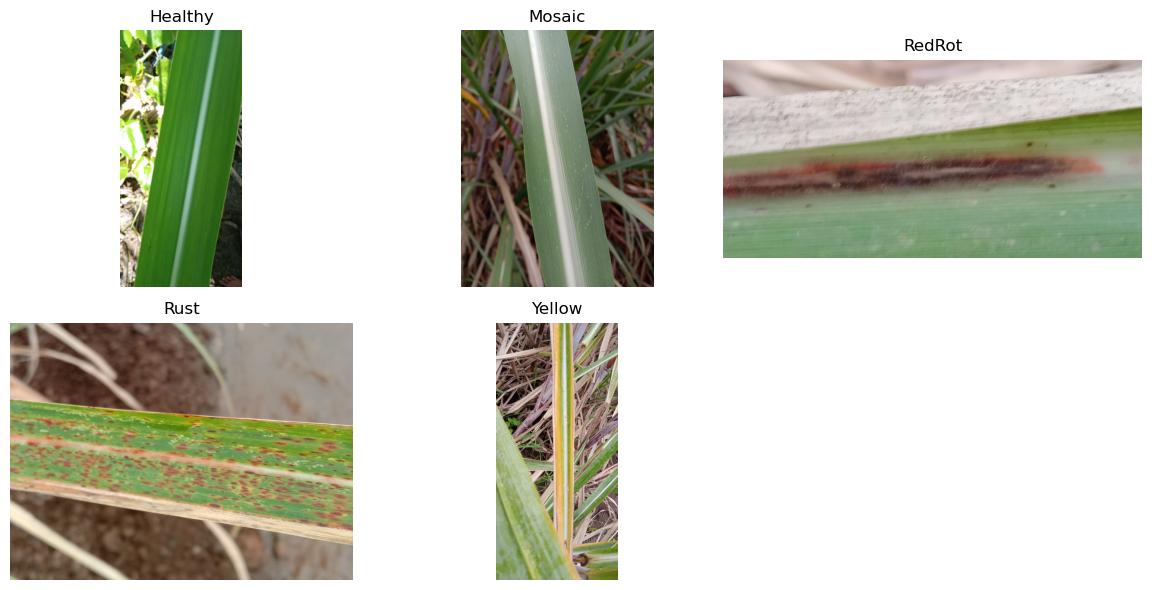

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math

base_dir = "C:\\Users\\isiPr\\Desktop\\SugarcaneLeafDiseaseDataset"
classes = os.listdir(base_dir)
print("Classes :", classes)

for c in classes:
    print(c, ":", len(os.listdir(os.path.join(base_dir, c))), "images")

num_classes = len(classes)
cols = 3  # nombre de colonnes
rows = math.ceil(num_classes / cols)  # nombre de lignes

plt.figure(figsize=(12, 6))
for i, c in enumerate(classes):
    img_path = os.path.join(base_dir, c, random.choice(os.listdir(os.path.join(base_dir, c))))
    img = mpimg.imread(img_path)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import splitfolders

splitfolders.ratio(base_dir, output="data_split", seed=42, ratio=(0.7, 0.15, 0.15))


Copying files: 2521 files [00:17, 143.16 files/s]


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # ← AJOUT ICI
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input    # ← AJOUT ICI
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input    # ← AJOUT ICI
)

train_gen = train_datagen.flow_from_directory(
    'data_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'data_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    'data_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1762 images belonging to 5 classes.
Found 376 images belonging to 5 classes.
Found 384 images belonging to 5 classes.


In [8]:
import pandas as pd

class_counts = {c: len(os.listdir(os.path.join(base_dir, c))) for c in classes}
df = pd.DataFrame(list(class_counts.items()), columns=['Classe', 'Nombre d’images'])
print(df)


    Classe  Nombre d’images
0  Healthy              522
1   Mosaic              462
2   RedRot              518
3     Rust              514
4   Yellow              505


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [10]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# On gèle les couches pour ne pas réentraîner toute la base
for layer in base_model.layers:
    layer.trainable = False


In [11]:
num_classes = train_gen.num_classes  # Nombre de classes du dataset

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [12]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
#for layer in base_model.layers[-30:]:  # On "dégèle" les 30 dernières couches
  #  layer.trainable = True
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3610 - loss: 1.6332 - val_accuracy: 0.6489 - val_loss: 0.9712
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5965 - loss: 1.0444 - val_accuracy: 0.7207 - val_loss: 0.7811
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6822 - loss: 0.8304 - val_accuracy: 0.7527 - val_loss: 0.6874
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7259 - loss: 0.7230 - val_accuracy: 0.7926 - val_loss: 0.6032
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7770 - loss: 0.6198 - val_accuracy: 0.7979 - val_loss: 0.5559
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7934 - loss: 0.5598 - val_accuracy: 0.8085 - val_loss: 0.5212
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7985 - loss: 0.5329 - val_accuracy: 0.8138 - val_loss: 0.5073
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8184 - loss: 0.4953 - val_accuracy: 0.8245 - val_loss

In [16]:
loss, acc = model.evaluate(test_gen)
print("Test accuracy:", acc)


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8490 - loss: 0.4489
Test accuracy: 0.8489583134651184


In [17]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # IMPORTANT : LR TRÈS BAS
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================================
# 1️⃣  Définir les callbacks
# =========================================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                # arrête si val_loss ne s’améliore plus après 3 epochs
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',           # le fichier du meilleur modèle sauvegardé
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

# =========================================
# 2️⃣  LANCER L’ENTRAÎNEMENT AVEC CALLBACKS
# =========================================

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=75,                # tu peux mettre 50, EarlyStopping stoppera automatiquement
    callbacks=callbacks,      # ← AJOUT ICI
    verbose=1
)



Epoch 1/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7268 - loss: 0.7652  
Epoch 1: val_loss improved from None to 0.38831, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7696 - loss: 0.6421 - val_accuracy: 0.8484 - val_loss: 0.3883
Epoch 2/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8320 - loss: 0.4682  
Epoch 2: val_loss improved from 0.38831 to 0.36412, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8445 - loss: 0.4388 - val_accuracy: 0.8617 - val_loss: 0.3641
Epoch 3/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8711 - loss: 0.3951  
Epoch 3: val_loss improved from 0.36412 to 0.32216, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8723 - loss: 0.3836 - val_accuracy: 0.8723 - val_loss: 0.3222
Epoch 4/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9062 - loss: 0.2997  
Epoch 4: val_loss improved from 0.32216 to 0.31491, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9075 - loss: 0.2886 - val_accuracy: 0.8910 - val_loss: 0.3149
Epoch 5/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9152 - loss: 0.2730  
Epoch 5: val_loss improved from 0.31491 to 0.29197, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9098 - loss: 0.2693 - val_accuracy: 0.8883 - val_loss: 0.2920
Epoch 6/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9211 - loss: 0.2427  
Epoch 6: val_loss improved from 0.29197 to 0.27332, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9177 - loss: 0.2406 - val_accuracy: 0.9069 - val_loss: 0.2733
Epoch 7/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9231 - loss: 0.1974  
Epoch 7: val_loss improved from 0.27332 to 0.25061, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9291 - loss: 0.1913 - val_accuracy: 0.9176 - val_loss: 0.2506
Epoch 8/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9393 - loss: 0.1937  
Epoch 8: val_loss improved from 0.25061 to 0.24502, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9404 - loss: 0.1845 - val_accuracy: 0.9176 - val_loss: 0.2450
Epoch 9/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9474 - loss: 0.1597  
Epoch 9: val_loss did not improve from 0.24502
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9472 - loss: 0.1607 - val_accuracy: 0.9122 - val_loss: 0.2516
Epoch 10/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9504 - loss: 0.1430  
Epoch 10: val_loss did not improve from 0.24502
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9518 - loss: 0.1474 - val_accuracy: 0.9096 - val_loss: 0.2473
Epoch 11/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9589 - loss: 0.1287  
Epoch 11: val_loss improved from 0.24502 to 0.23211, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9557 - loss: 0.1342 - val_accuracy: 0.9229 - val_loss: 0.2321
Epoch 12/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9644 - loss: 0.1140  
Epoch 12: val_loss did not improve from 0.23211
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9625 - loss: 0.1207 - val_accuracy: 0.9255 - val_loss: 0.2381
Epoch 13/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9625 - loss: 0.1236  
Epoch 13: val_loss did not improve from 0.23211
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9671 - loss: 0.1138 - val_accuracy: 0.9229 - val_loss: 0.2375
Epoch 14/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9696 - loss: 0.0946  
Epoch 14: val_loss improved from 0.23211 to 0.23051, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9682 - loss: 0.1002 - val_accuracy: 0.9309 - val_loss: 0.2305
Epoch 15/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9732 - loss: 0.0969  
Epoch 15: val_loss improved from 0.23051 to 0.20753, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9762 - loss: 0.0894 - val_accuracy: 0.9362 - val_loss: 0.2075
Epoch 16/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9772 - loss: 0.0872  
Epoch 16: val_loss did not improve from 0.20753
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9728 - loss: 0.0943 - val_accuracy: 0.9362 - val_loss: 0.2108
Epoch 17/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9689 - loss: 0.0807  
Epoch 17: val_loss did not improve from 0.20753
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9722 - loss: 0.0801 - val_accuracy: 0.9282 - val_loss: 0.2352
Epoch 18/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9743 - loss: 0.0872  
Epoch 18: val_loss did not improve from 0.20753
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9779 - loss: 0.0807 - val_accuracy: 0.9255 - val_loss: 0.2130
Epoch 19/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9795 - loss: 0.0669  
Epoch 19: val_loss did not improve from 0.20753


56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9773 - loss: 0.0786 - val_accuracy: 0.9362 - val_loss: 0.1871
Epoch 21/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9852 - loss: 0.0583  
Epoch 21: val_loss improved from 0.18706 to 0.18013, saving model to best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9835 - loss: 0.0582 - val_accuracy: 0.9468 - val_loss: 0.1801
Epoch 22/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9849 - loss: 0.0600  
Epoch 22: val_loss did not improve from 0.18013
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9835 - loss: 0.0593 - val_accuracy: 0.9441 - val_loss: 0.1885
Epoch 23/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9889 - loss: 0.0456  
Epoch 23: val_loss did not improve from 0.18013
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9892 - loss: 0.0447 - val_accuracy: 0.9415 - val_loss: 0.1947
Epoch 24/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9880 - loss: 0.0447  
Epoch 24: val_loss did not improve from 0.18013
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9864 - loss: 0.0470 - val_accuracy: 0.9388 - val_loss: 0.1923
Epoch 25/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9838 - loss: 0.0501  
Epoch 25: val_loss improved from 0.18013 to 0.17

56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9835 - loss: 0.0523 - val_accuracy: 0.9388 - val_loss: 0.1783
Epoch 26/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9811 - loss: 0.0508  
Epoch 26: val_loss did not improve from 0.17835
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9847 - loss: 0.0439 - val_accuracy: 0.9415 - val_loss: 0.1940
Epoch 27/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9867 - loss: 0.0496  
Epoch 27: val_loss did not improve from 0.17835
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9847 - loss: 0.0510 - val_accuracy: 0.9282 - val_loss: 0.2077
Epoch 28/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9860 - loss: 0.0425  
Epoch 28: val_loss did not improve from 0.17835
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9881 - loss: 0.0437 - val_accuracy: 0.9335 - val_loss: 0.2040
Epoch 29/75
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9911 - loss: 0.0331  
Epoch 29: val_loss did not improve from 0.17835


In [19]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

loss, acc = model.evaluate(test_gen)
print("Final test accuracy:", acc)


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9375 - loss: 0.1880 
Final test accuracy: 0.9375


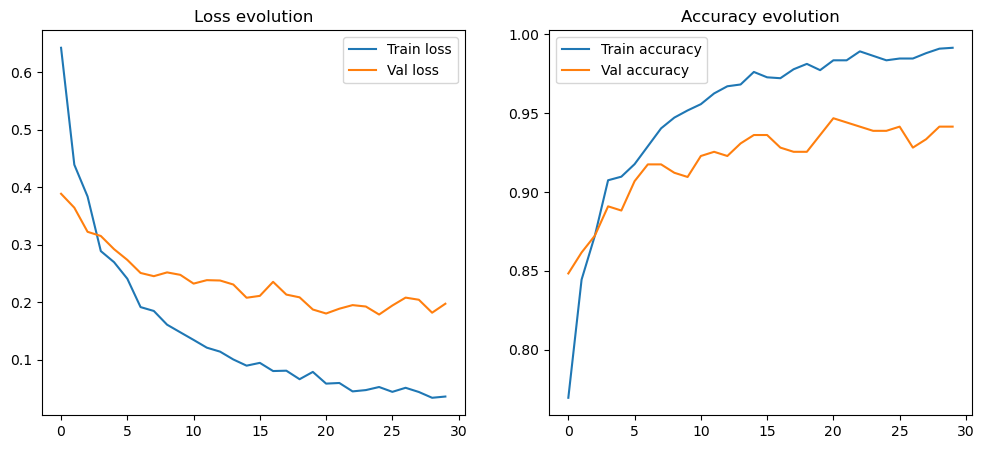

In [21]:
plt.figure(figsize=(12,5))

# LOSS
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss evolution")

# ACCURACY
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title("Accuracy evolution")

plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step  


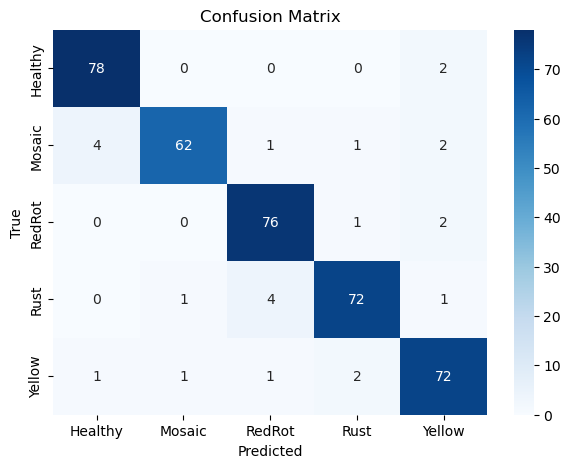

              precision    recall  f1-score   support

     Healthy       0.94      0.97      0.96        80
      Mosaic       0.97      0.89      0.93        70
      RedRot       0.93      0.96      0.94        79
        Rust       0.95      0.92      0.94        78
      Yellow       0.91      0.94      0.92        77

    accuracy                           0.94       384
   macro avg       0.94      0.94      0.94       384
weighted avg       0.94      0.94      0.94       384



In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_labels, target_names=class_names))


In [23]:
model.save("best_model.keras")


In [24]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model2 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model2.trainable = False  # on gèle les couches pour le transfer learning


In [25]:
num_classes = train_gen.num_classes

x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs=base_model2.input, outputs=output)


In [26]:
model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [27]:
history2 = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2355 - loss: 1.6852 - val_accuracy: 0.4096 - val_loss: 1.4226
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3082 - loss: 1.5258 - val_accuracy: 0.5319 - val_loss: 1.2839
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4359 - loss: 1.3681 - val_accuracy: 0.5612 - val_loss: 1.1853
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4586 - loss: 1.3215 - val_accuracy: 0.5878 - val_loss: 1.1171
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.4847 - loss: 1.2601 - val_accuracy: 0.5798 - val_loss: 1.0652
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5238 - loss: 1.2026 - val_accuracy: 0.6090 - val_loss: 1.0185
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5533 - loss: 1.1386 - val_accuracy: 0.6197 - val_loss: 0.9938
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5499 - loss: 1.1210 - val_accuracy: 0.6277 - val_loss

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    'best_model2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)



callbacks = [early_stop, checkpoint]


base_model2.trainable = True

# On ne fine-tune que les 50 dernières couches
for layer in base_model2.layers[:-50]:
    layer.trainable = False

model2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2_ft = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=75,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/75


KeyboardInterrupt: 

In [33]:
loss2, acc2 = model2.evaluate(test_gen)
print("Test accuracy EfficientNetB0:", acc2)


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 982ms/step - accuracy: 0.8594 - loss: 0.4455
Test accuracy EfficientNetB0: 0.859375


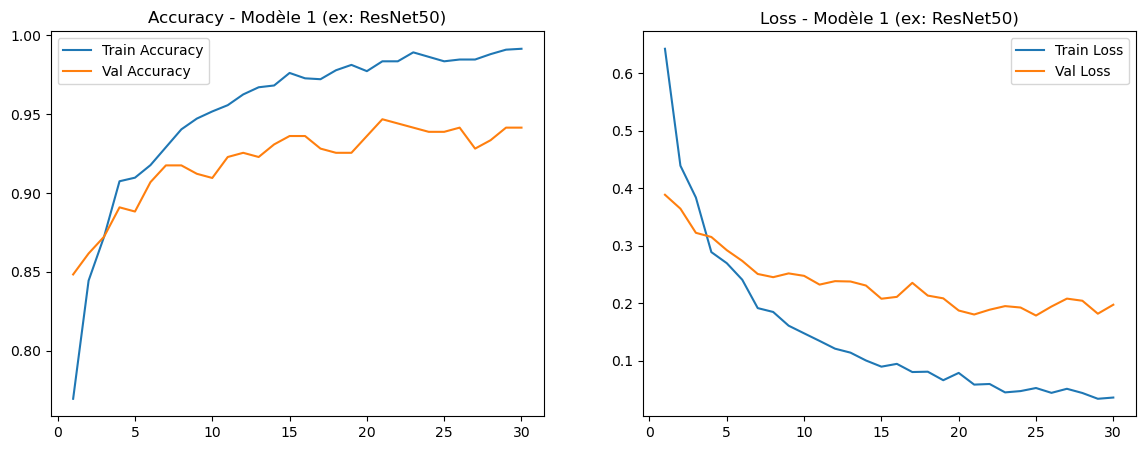

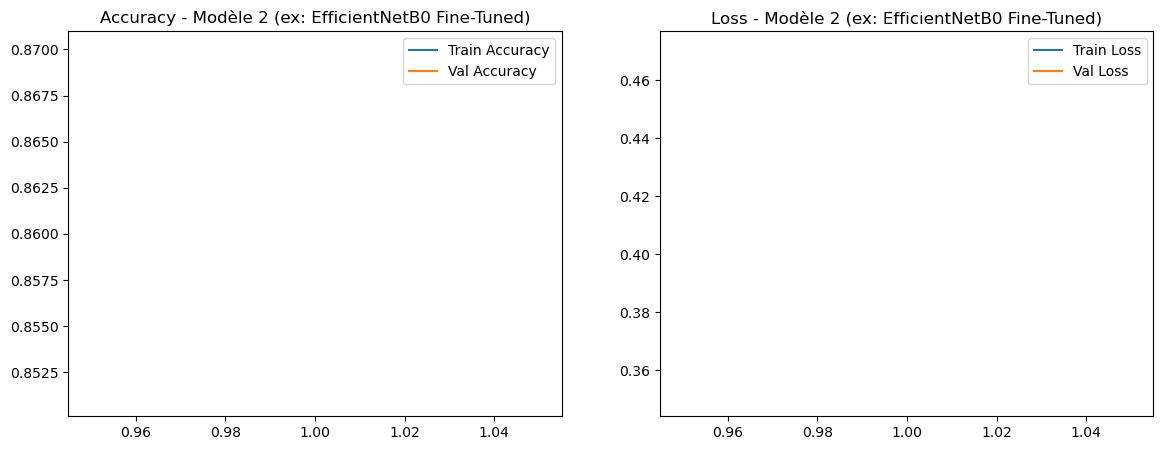

In [39]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'Loss - {title}')
    plt.legend()

    plt.show()

# Remplace ici par tes vrais objets history
plot_history(history, "Modèle 1 (ex: ResNet50)")
plot_history(history2_ft, "Modèle 2 (ex: EfficientNetB0 Fine-Tuned)")


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


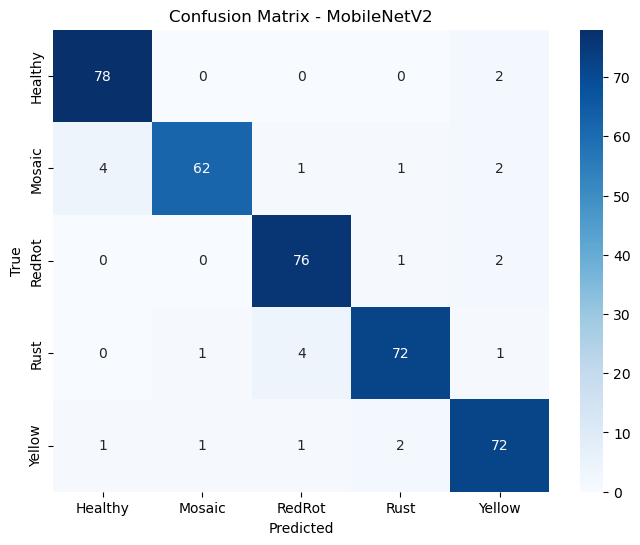


Classification Report :

              precision    recall  f1-score   support

     Healthy       0.94      0.97      0.96        80
      Mosaic       0.97      0.89      0.93        70
      RedRot       0.93      0.96      0.94        79
        Rust       0.95      0.92      0.94        78
      Yellow       0.91      0.94      0.92        77

    accuracy                           0.94       384
   macro avg       0.94      0.94      0.94       384
weighted avg       0.94      0.94      0.94       384



In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Vrai labels
y_true = test_gen.classes

# Prédictions du modèle 
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Noms des classes
class_names = list(test_gen.class_indices.keys())

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RES")
plt.show()

print("\nClassification Report :\n")
print(classification_report(y_true, y_pred, target_names=class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 918ms/step


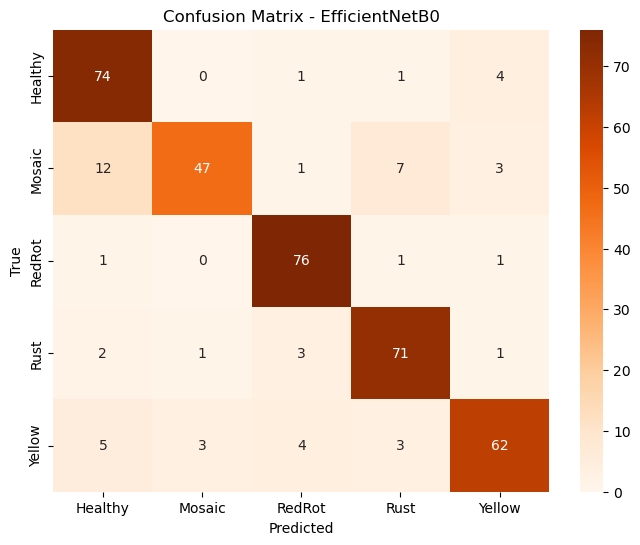


Classification Report :

              precision    recall  f1-score   support

     Healthy       0.79      0.93      0.85        80
      Mosaic       0.92      0.67      0.78        70
      RedRot       0.89      0.96      0.93        79
        Rust       0.86      0.91      0.88        78
      Yellow       0.87      0.81      0.84        77

    accuracy                           0.86       384
   macro avg       0.87      0.85      0.85       384
weighted avg       0.86      0.86      0.86       384



In [42]:
y_pred2 = np.argmax(model2.predict(test_gen), axis=1)

cm2 = confusion_matrix(y_true, y_pred2)

plt.figure(figsize=(8,6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()

print("\nClassification Report :\n")
print(classification_report(y_true, y_pred2, target_names=class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step  


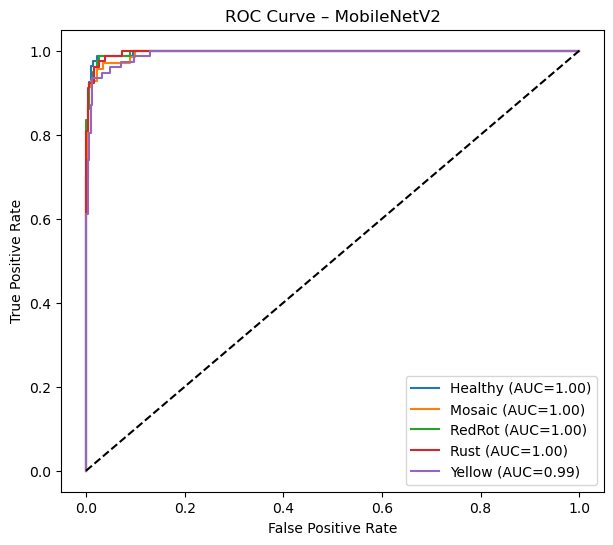

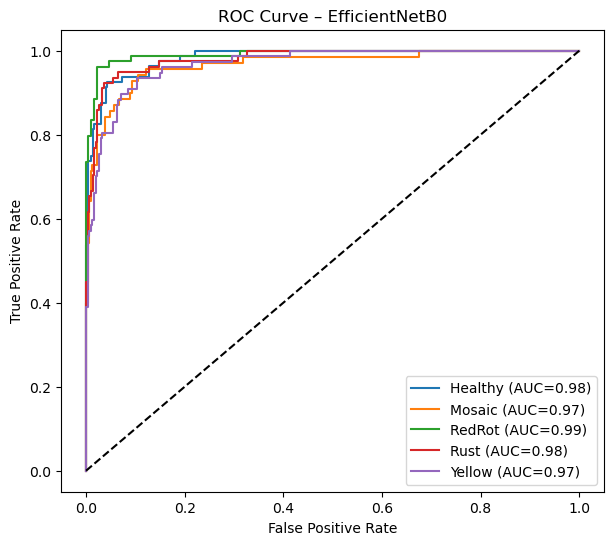

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
# Binariser les labels

class_names = sorted(os.listdir("data_split/train"))
num_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Prédictions probas
probs1 = model.predict(test_gen)
probs2 = model2.predict(test_gen)

def plot_roc(probs, title):
    plt.figure(figsize=(7,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

plot_roc(probs1, "ROC Curve – MobileNetV2")
plot_roc(probs2, "ROC Curve – EfficientNetB0")


In [114]:
from tensorflow.keras.models import load_model
import os
import numpy as np
from PIL import Image
import io

# Charger ton meilleur modèle
model = load_model("best_model.h5")

# Récupérer les classes depuis le dossier split
class_names = sorted(os.listdir("data_split/train"))

print("Classes chargées :", class_names)


Classes chargées : ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


In [115]:
from tensorflow.keras.applications.resnet import preprocess_input

def preprocess_image(img_bytes):
    img = Image.open(img_bytes).convert("RGB")
    img = img.resize((224, 224))

    img = np.array(img)
    img = preprocess_input(img)   # ⬅ IMPORTANT !
    img = np.expand_dims(img, axis=0)

    return img, Image.open(img_bytes).resize((224, 224))


In [118]:
import ipywidgets as widgets
from IPython.display import display

out = widgets.Output()

def upload_change(change):
    with out:
        out.clear_output()

        if uploader.value:
            value = uploader.value

            # Compatibilité Colab + Jupyter
            if isinstance(value, dict):          # COLAB
                file_info = list(value.values())[0]
            elif isinstance(value, tuple):       # JUPYTER
                file_info = value[0]
            else:
                print("Format inattendu :", type(value))
                return

            file_content = file_info['content']

            # Prétraitement
            x, img = preprocess_image(io.BytesIO(file_content))

            # Prediction
            preds = model.predict(x)
            predicted_index = np.argmax(preds)
            predicted_name = class_names[predicted_index]

            display(img)
            print("✨ Prédiction :", predicted_name)

# Widget d’upload
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(upload_change, names='value')

display(widgets.HTML("<h3>Uploader une image :</h3>"))
display(uploader)
display(out)


HTML(value='<h3>Uploader une image :</h3>')

FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [119]:
!pip install streamlit


In [120]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import os

# Charger modèle
model = load_model("best_model.h5")

# Charger noms des classes
class_names = sorted(os.listdir("data_split/train"))

st.title("🌿 Sugarcane Leaf Disease Classifier")
st.write("Upload an image and get the disease prediction.")

uploaded_file = st.file_uploader("Choose an image", type=["jpg", "png", "jpeg"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Image Uploaded", width=300)

    img = image.resize((224, 224))
    x = np.array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    idx = np.argmax(preds)

    st.success(f"Prediction: **{class_names[idx]}**")


Writing app.py


In [121]:
!streamlit run app.py


^C
